## Using Tweets to Predict Stock Prices: Data Joining, Cleaning, Sentiment Creation

Can we predict if a stock will go up or down based on twitter sentiment from that day?

This file joins datasets from twitter, from the stock index, and from the S&P 500.

<b>Import necessary libraries</b>

In [2]:
import pandas as pd
import datetime
import missingno
import os
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import pytz

est = pytz.timezone('US/Eastern')
utc = pytz.utc

import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import datetime
from datetime import timedelta

from copy import deepcopy

import pandas as pd
import datetime
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from textblob import TextBlob

# Show entire column
pd.set_option("display.max_colwidth", -1)

#### First, create the space to load datasets from either the operating system, or a user specified path

In [3]:
#note for os structure
cd = os.getcwd()
raw_data_directory_path = "/".join(cd.split("/")[:-1]) + "/data/raw/"
processed_data_directory_path = "/".join(cd.split("/")[:-1]) + "/data/processed/"

In [4]:
#or enter your appriate path/paths here if the above doesn't work, up to the data folder you put the 
#raw and processed data folders in
                            #ENTER THE BEGINNING OF YOur PATH TO RAW AND PROCESSED HERE
raw_data_directory_path = 'C:/Users/heath/Desktop/W207/w207_final_project/w207_final_project/data/raw/'
processed_data_directory_path = 'C:/Users/heath/Desktop/W207/w207_final_project/w207_final_project/data/processed/'

<b>Get and join tweet data.  Note that the tweet data files are too large to keep in the github repo. </b>
For reference, the data can be found at the following locations:
    

In [5]:
tweets = pd.read_csv(raw_data_directory_path+'tweet_data/Tweet.csv')
company_tweets = pd.read_csv(raw_data_directory_path +'tweet_data/Company_Tweet.csv')
company = pd.read_csv(raw_data_directory_path +'tweet_data/Company.csv')
tweet_combo = pd.merge(tweets, company_tweets)
tweet_combo = pd.merge(tweet_combo, company)
tweet_combo.ticker_symbol.unique()

#need to convert the tweet post date to date time and also account for stock prices being in est, so make tweets est
tweet_combo.post_date = tweet_combo.post_date.apply(lambda x: datetime.datetime.fromtimestamp(x).astimezone(est).strftime('%Y-%m-%d'))
tweet_combo.post_date = pd.to_datetime(tweet_combo.post_date, format='%Y-%m-%d')

#check min tweet date
print('min tweet date:', tweet_combo.post_date.min())

min tweet date: 2014-12-31 00:00:00


<b>Get stock data for the companies we have tweets for, and the S&P 500 data for reference.  Build dataset with this data.</b>
For reference, the data can be found in the following locations:

In [6]:
companynasdaq = pd.read_csv(raw_data_directory_path + 'stock_data/Company.csv')
company_val = pd.read_csv(raw_data_directory_path+'stock_data/CompanyValues.csv')
company_val.day_date = pd.to_datetime(company_val.day_date,format='%Y-%m-%d %H:%M:%S')

#we want to drop the duplicates and keep the max per day with hour min sec, and then convert back to just looking at the day.
#keeping the day makes it easier to join the datasets on tweets that day compared to market close and adjustment per day
company_val .sort_values(['day_date'], ascending=True, inplace=True)
company_val = company_val.drop_duplicates(subset = ['day_date', 'ticker_symbol'], keep = 'last')

#get stock data 2015 plus to match our tweet data dates
company_val.day_date = pd.to_datetime(company_val.day_date,format='%Y-%m-%d')
company_val = company_val.loc[company_val.day_date >= '2015-01-01']

#check to make sure filter worked
print('min stock date:', company_val.day_date.min())

stock_prices = pd.merge(company_val, companynasdaq)
stock_prices.sort_values(['day_date'], ascending=True, inplace=True)

#create stock return % change from previous day
stock_prices['return'] = stock_prices.groupby('ticker_symbol')['close_value'].pct_change()

#'GOOG' and 'GOOGL' are actually two different stocks from Google Inc.
#https://seekingalpha.com/article/4430928-which-google-stock-is-a-better-buy-goog-or-googl

#still only want most recent value per day
stock_prices = stock_prices.drop_duplicates(subset = ['day_date', 'ticker_symbol'], keep = 'last')

tickers = list(stock_prices.ticker_symbol.unique())

#S&P data
sp500 = pd.read_csv(raw_data_directory_path+'stock_data/SP500_historical.csv')
sp500.Date = pd.to_datetime(sp500.Date)
sp500.sort_values(['Date'], ascending=True, inplace=True)
sp500.columns = ['day_date', 'sp_open', 'sp_high', 'sp_low', 'sp_close']
sp500['sp_pct_return'] = sp500['sp_close'].pct_change()
spcols = ['day_date', 'sp_close', 'sp_pct_return']
sp500 = sp500[spcols]

#merge S&P with company stock prices
stock_prices = pd.merge(stock_prices, sp500)

min stock date: 2015-01-01 00:00:00


<b>Join Final Datasets - Stock Data with S&P 500 and Tweet Data </b>

In [7]:
#join on date and ticker symbol to get the stock price for the company for the date of the post
final_df = pd.merge(tweet_combo, stock_prices, left_on = ['post_date', 'ticker_symbol'], right_on = ['day_date', 'ticker_symbol'])
final_df = final_df.rename(columns = {'company_name_x': 'company_name'})
final_df = final_df.drop(['company_name_y'], axis=1)

#export cleaned data to csv as needed:
#final_df.to_csv(processed_data_directory_path+'cleaned_data.csv')

print('Initial length of tweet data', len(tweet_combo))
print('Rows dropped when merging stock data and S&P data:', len(tweet_combo) - len(final_df))

#note that cleaned data features include:
    #joining tweet datasets on tweet IDs and then to stock data on post date (tweet data) and day date (stock data) and ticker symbol
    #making return per stock (percent change from previous day) - make over week for final dataset
    #converting datetimes and considerations for est
    #keeping stock data greater than 2015 to match our tweet data
    #acsending date sorting
    #added S&P 500 data - close value and percent change from previous day

Initial length of tweet data 4336445
Rows dropped when merging stock data and S&P data: 631024


<b>Data Exploration ..</b>

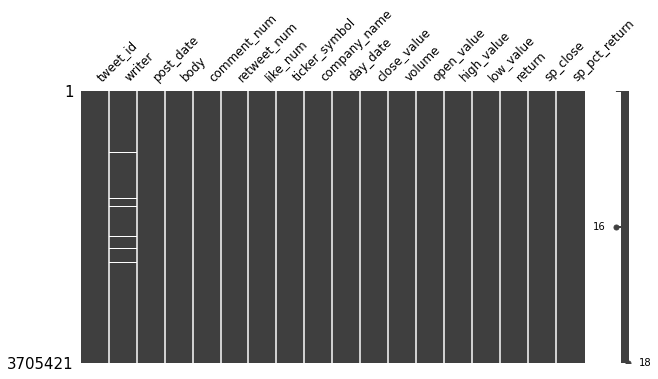

In [8]:
#produces a nice heat style of missing data - I would say we don't really have missing data in the final df
missingno.matrix(final_df,figsize=(10,5), fontsize=12)

In [9]:
final_df.describe()

,tweet_id,comment_num,retweet_num,like_num,close_value,volume,open_value,high_value,low_value,return,sp_close,sp_pct_return
count,3.705421e+06,3.705421e+06,3.705421e+06,3.705421e+06,3.705421e+06,3.705421e+06,3.705421e+06,3.705421e+06,3.705421e+06,3.705421e+06,3.705421e+06,3.703729e+06
mean,8.825025e+17,2.869946e-01,6.177506e-01,2.027946e+00,4.601062e+02,2.035185e+07,4.600215e+02,4.651276e+02,4.545439e+02,1.243132e-03,2.451504e+03,2.834690e-04
std,1.925688e+17,1.868682e+00,7.045150e+00,1.339141e+01,4.657105e+02,2.263473e+07,4.657048e+02,4.700767e+02,4.607222e+02,2.608636e-02,3.605926e+02,8.613595e-03
min,5.508798e+17,0.000000e+00,0.000000e+00,0.000000e+00,4.029000e+01,3.475180e+05,4.034000e+01,4.074000e+01,3.972000e+01,-1.390153e-01,1.829080e+03,-4.097924e-02
25%,7.195717e+17,0.000000e+00,0.000000e+00,0.000000e+00,1.287000e+02,3.769453e+06,1.285800e+02,1.296200e+02,1.278500e+02,-8.679704e-03,2.102150e+03,-2.986777e-03
50%,8.793614e+17,0.000000e+00,0.000000e+00,0.000000e+00,2.550100e+02,1.036460e+07,2.550500e+02,2.590000e+02,2.501800e+02,1.008488e-03,2.432540e+03,3.734622e-04
75%,1.054324e+18,0.000000e+00,0.000000e+00,1.000000e+00,7.042400e+02,3.059640e+07,7.036700e+02,7.116000e+02,6.968000e+02,1.152093e-02,2.784700e+03,4.620139e-03
max,1.212160e+18,6.310000e+02,9.990000e+02,9.990000e+02,2.039510e+03,1.691150e+08,2.038110e+03,2.050500e+03,2.013000e+03,1.766923e-01,3.240020e+03,4.959381e-02


<b>For ease of notebook conversion, renaming final df to main df<b>

In [12]:
main_df = final_df

## VADAR Sentiment Intensity Analyzer

In [13]:
sid = SentimentIntensityAnalyzer()
main_df['sent_scores'] = main_df['body'].apply(lambda body: sid.polarity_scores(body))

#investigate the compound score as this is most indicative of tweet sentiment
#VADAR sentiment analyzer does not require much cleaning as things like capitailization and punctuation are important in the 
#classification
main_df['compound']  = main_df['sent_scores'].apply(lambda score_dict: score_dict['compound'])

#postive and negative can be derived from the values given by the compound score
#closer to 1 is postive while closer to -1 is negative
main_df['tweet_sent'] = main_df['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')
main_df['positive'] = main_df['tweet_sent'].apply(lambda c: 1 if c =='pos' else 0)
main_df['negative'] = main_df['tweet_sent'].apply(lambda c: 1 if c =='neg' else 0)

#compbine comments, retweets, and likes into one total reaction score
main_df['reaction_num'] = main_df['comment_num'] + main_df['retweet_num'] + main_df['like_num']

#dropping where compound is zero to limit neutral tweets as we want to see the impact of postive and negative sentiment
#on the market
main_df = main_df.loc[~(main_df['compound'] == 0)]

#if export is wanted
#main_df.to_csv(processed_data_directory_path+'main_df.csv')

#check columns created
main_df.columns

Index(['tweet_id', 'writer', 'post_date', 'body', 'comment_num', 'retweet_num',
       'like_num', 'ticker_symbol', 'company_name', 'day_date', 'close_value',
       'volume', 'open_value', 'high_value', 'low_value', 'return', 'sp_close',
       'sp_pct_return', 'sent_scores', 'compound', 'tweet_sent', 'positive',
       'negative', 'reaction_num'],
      dtype='object')

## Sentiment Classification - Flair

Note that due to so much negativity found in the data, as well as the length of processing time, this analyzer was not selected for final analysis.  See the sentiment analydid comparison notebook for more details.  Keeping in nbrawconvet for reference.

## Sentiment Classification - Text Blob

In [ ]:
def predict_textblob_sentiment(input_tweet):
    tb = TextBlob(input_tweet["body"])
    input_tweet['TB_polarity'] = tb.sentiment.polarity
    input_tweet['TB_subjectivity'] =  tb.sentiment.subjectivity
    return input_tweet



# predict sentiment of tweet
#test_df = test_df.apply(predict_textblob_sentiment,axis=1)
main_df = main_df.apply(predict_textblob_sentiment,axis=1)

In [ ]:
# View tweet polarity
plt.hist(main_df['TB_polarity'])
#plt.xticks(range(-1,2))
plt.title('Tweet TextBlob Polarity')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

#### Add summarization logic:
### We want to build a weekly dataset to get a handle on the data, and a daily to use for deeper analysis

In [ ]:
#define summarization logic
logic = {'open_value'  : 'first',
         'high_value'  : 'max',
         'low_value'   : 'min',
         'close_value' : 'last',
         'volume': 'sum',
        'reaction_num': 'sum',
        'compound': 'mean',
        'writer': 'nunique',
        'body': 'count',
        'positive': 'sum',
        'negative': 'sum',
        'sp_close': 'last'}

In [ ]:
#weekly dataset construction
test_df = deepcopy(main_df)
offset = pd.offsets.timedelta(days=6)
test_df.set_index('post_date', inplace = True)
test_df.index = pd.to_datetime(test_df.index)
test_df.index = pd.to_datetime(test_df.index)
#create weekly dataset per ticker symbol
summary_df = test_df.groupby('ticker_symbol').resample('W', loffset=offset).apply(logic)
summary_df['pct_change'] = summary_df.groupby('ticker_symbol')['close_value'].pct_change().mul(100)
summary_df['sp_pct_change'] = summary_df.groupby('ticker_symbol')['sp_close'].pct_change().mul(100)
summary_df['ratio_pos'] = summary_df['positive'] / (summary_df['positive'] + summary_df['negative'])
summary_df['ratio_neg'] = summary_df['negative'] / (summary_df['positive'] + summary_df['negative'])

#build daily dataset
test_df = deepcopy(main_df)
test_df.set_index('post_date', inplace = True)
test_df.index = pd.to_datetime(test_df.index)
daily_df = test_df.groupby('ticker_symbol').resample('D').apply(logic)
daily_df['pct_change'] = daily_df.groupby('ticker_symbol')['close_value'].pct_change().mul(100)
daily_df['sp_pct_change'] = daily_df.groupby('ticker_symbol')['sp_close'].pct_change().mul(100)
daily_df['ratio_pos'] = daily_df['positive'] / (daily_df['positive'] + daily_df['negative'])
daily_df['ratio_neg'] = daily_df['negative'] / (daily_df['positive'] + daily_df['negative'])
daily_df.dropna(inplace=True)
